# Example 1: Sandstone Model

In [1]:
# Importing
import theano.tensor as T
import sys, os
sys.path.append("../GeMpy")

# Importing GeMpy modules
import GeMpy

# Reloading (only for development purposes)
import importlib
importlib.reload(GeMpy)

# Usuful packages
import numpy as np
import pandas as pn

import matplotlib.pyplot as plt

# This was to choose the gpu
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Default options of printin
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

%matplotlib inline
#%matplotlib notebook

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


First we make a GeMpy instance with most of the parameters default (except range that is given by the project). Then we also fix the extension and the resolution of the domain we want to interpolate. Finally we compile the function, only needed once every time we open the project (the guys of theano they are working on letting loading compiled files, even though in our case it is not a big deal).

*General note. So far the reescaling factor is calculated for all series at the same time. GeoModeller does it individually for every potential field. I have to look better what this parameter exactly means*

In [2]:
geo_data = GeMpy.import_data([696000,747000,6863000,6950000,-20000, 2000],[ 40, 40, 80],
                         path_f = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

All input data is stored in pandas dataframes under, ```self.Data.Interances``` and ```self.Data.Foliations```:

In [3]:
#GeMpy.i_set_data(geo_data)

In case of disconformities, we can define which formation belong to which series using a dictionary. Until python 3.6 is important to specify the order of the series otherwise is random

In [4]:
GeMpy.set_data_series(geo_data, {"EarlyGranite_Series":geo_data.formations[-1], 
                      "BIF_Series":(geo_data.formations[0], geo_data.formations[1]),
                      "SimpleMafic_Series":geo_data.formations[2]}, 
                       order_series = ["EarlyGranite_Series",
                              "BIF_Series",
                              "SimpleMafic_Series"], verbose=0)

Now in the data frame we should have the series column too

In [5]:
GeMpy.get_raw_data(geo_data).head()

G_x  G_y  G_z              X             Y            Z  \
interfaces 0  NaN  NaN  NaN  735484.817806  6.891936e+06 -1819.319309   
           1  NaN  NaN  NaN  729854.915982  6.891938e+06 -1432.263309   
           2  NaN  NaN  NaN  724084.267161  6.891939e+06 -4739.830309   
           3  NaN  NaN  NaN  733521.625000  6.895282e+06   521.555240   
           4  NaN  NaN  NaN  721933.375000  6.884592e+06   496.669295   

              azimuth  dip     formation  polarity      series  
interfaces 0      NaN  NaN  SimpleMafic2       NaN  BIF_Series  
           1      NaN  NaN  SimpleMafic2       NaN  BIF_Series  
           2      NaN  NaN  SimpleMafic2       NaN  BIF_Series  
           3      NaN  NaN  SimpleMafic2       NaN  BIF_Series  
           4      NaN  NaN  SimpleMafic2       NaN  BIF_Series

Next step is the creating of a grid. So far only regular. By default it takes the extent and the resolution given in the `import_data` method.

In [6]:
# Create a class Grid so far just regular grid
GeMpy.set_grid(geo_data)
GeMpy.get_grid(geo_data)

array([[  696000.      ,  6863000.      ,   -20000.      ],
       [  696000.      ,  6863000.      ,   -19721.519531],
       [  696000.      ,  6863000.      ,   -19443.037109],
       ..., 
       [  747000.      ,  6950000.      ,     1443.037964],
       [  747000.      ,  6950000.      ,     1721.519043],
       [  747000.      ,  6950000.      ,     2000.      ]], dtype=float32)

## Plotting raw data

The object Plot is created automatically as we call the methods above. This object contains some methods to plot the data and the results.

It is possible to plot a 2D projection of the data in a specific direction using the following method. Also is possible to choose the series you want to plot. Additionally all the key arguments of seaborn lmplot can be used.

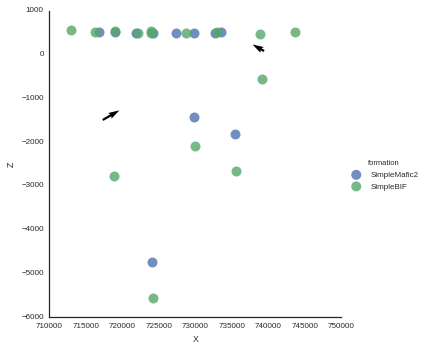

In [7]:
GeMpy.plot_data(geo_data, 'y', geo_data.series.columns.values[1])

## Class Interpolator

This class will take the data from the class Data and calculate potential fields and block. We can pass as key arguments all the variables of the interpolation. I recommend not to touch them if you do not know what are you doing. The default values should be good enough. Also the first time we execute the method, we will compile the theano function so it can take a bit of time.

In [8]:
GeMpy.set_interpolator(geo_data, u_grade = 2)

Now we could visualize the individual potential fields as follow:

###  Early granite

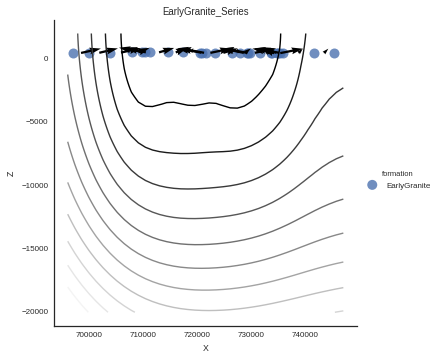

In [9]:
GeMpy.plot_potential_field(geo_data,10, n_pf=0)

### BIF Series

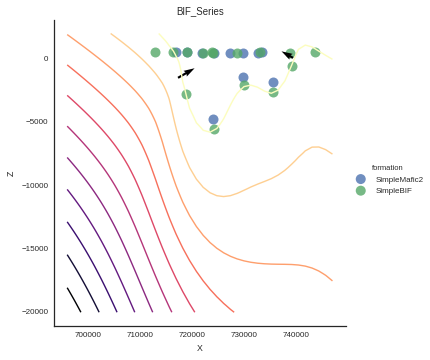

In [10]:
GeMpy.plot_potential_field(geo_data,13, n_pf=1, cmap = "magma",  plot_data = True,
                                        verbose = 5)

###  SImple mafic

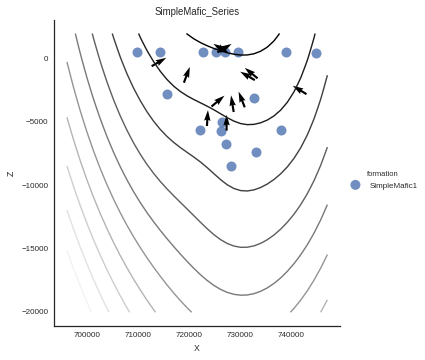

In [11]:
GeMpy.plot_potential_field(geo_data, 10, n_pf=2)

## Optimizing the export of lithologies

But usually the final result we want to get is the final block. The method `compute_block_model` will compute the block model, updating the attribute `block`. This attribute is a theano shared function that can return a 3D array (raveled) using the method `get_value()`.

In [12]:
GeMpy.compute_block_model(geo_data)

Final block computed

And again after computing the model in the Plot object we can use the method `plot_block_section` to see a 2D section of the model

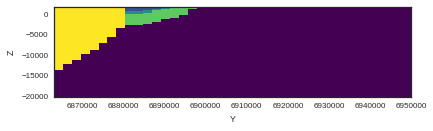

In [13]:
GeMpy.plot_section(geo_data, 13, direction='x')

## Export  to vtk. (*Under development*)

In [16]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)
gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

NameError: name 'sol' is not defined

## Performance Analysis

One of the advantages of theano is the posibility to create a full profile of the function. This has to be included in at the time of the creation of the function. At the moment it should be active (the downside is larger compilation time and I think also a bit in the computation so be careful if you need a fast call)

### CPU

The following profile is with a 2 core laptop. Nothing spectacular.

In [ ]:
%%timeit
# Compute the block
GeMpy.compute_block_model([0,1,2], verbose = 0)

In [ ]:
geo_data.interpolator.

Looking at the profile we can see that most of time is in pow operation (exponential). This probably is that the extent is huge and we are doing it with too much precision. I am working on it

In [17]:
geo_data.interpolator._interpolate.profile.summary()

Function profiling
  Message: ../GeMpy/DataManagement.py:980
  Time in 3 calls to Function.__call__: 1.657297e+01s
  Time in Function.fn.__call__: 1.657162e+01s (99.992%)
  Time in thunks: 1.618481e+01s (97.658%)
  Total compile time: 3.413099e+00s
    Number of Apply nodes: 621
    Theano Optimizer time: 4.843216e-01s
       Theano validate time: 8.306980e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.664996e+00s
       Import time 1.889227e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 9553.044s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  89.6%    89.6%      14.508s       1.41e-02s     C     1032     344   theano.tensor.elemwise.Elemwise
   5.3%    94.9%       0.857s       4.53e-03s     C      189      63   theano.tensor.elemwise.DimShuffle
   1.6%    96.5%       0.252s       7.64e-03s     C       33      11   theano.tensor.blas.Dot22
   1.3%    97.8%       0.214s       7.9

### GPU

In [ ]:
%%timeit

# Compute the block
GeMpy.compute_block_model([0,1,2], verbose = 0)

In [ ]:
geo_data.interpolator._interpolate.profile.summary()